In [29]:
# imports

import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [30]:
# project directory

base_path = Path(".")         
data_path = base_path / "data"  
results_path = base_path / "results" / "01_preprocessing" 

In [31]:
# loading the cases json file

cases_file = data_path / "cases.json"
with open(cases_file, "r", encoding="utf-8") as f:
    data = json.load(f)
cases = data["cases"]
len(cases)

2679

In [32]:
# label count check

true_count = sum(1 for c in cases if c["decision"] == True)
false_count = sum(1 for c in cases if c["decision"] == False)

print("True:", true_count)
print("False:", false_count)
print("Ratio:", true_count / (true_count + false_count))

True: 1711
False: 968
Ratio: 0.6386711459499813


In [33]:
# function for general text cleaning

def clean_text(text):
    if text is None:
        return ""
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [34]:
# defining the decision leakage words

decision_keywords = [
    r"\baffirm\w*\b",
    r"\brevers\w*\b",
    r"\bvacat\w*\b",
    r"\bremand\w*\b",
    r"\bguilty\b",
    r"\bnot guilty\b",
    r"\bliable\b",
    r"\bnot liable\b",
    r"\bacquit\w*\b",
    r"\bconvict\w*\b",
    r"\bdecision\b",
    r"\bholding\b",
    r"\bconclusion\b",
    r"\bjudgment\b",
    r"\bopinion\b",
]

In [35]:
# function to remove the entire ruling sentences

def remove_final_ruling(text):
    sentences = re.split(r'(?<=[\.\?\!])\s+', text)
    ruling_patterns = [
        r"judgment.*affirm",
        r"judgment.*reverse",
        r"judgment.*vacate",
        r"judgment.*remand",

        r"affirmed\b",
        r"reversed\b",
        r"vacated\b",
        r"remanded\b",

        r"the decision.*affirm",
        r"the decision.*reverse",
        r"the decision.*vacate",
        r"the decision.*remand",

        r"it is so ordered",
        r"the court.*affirm",
        r"the court.*reverse"
    ]

    cleaned = []
    for s in sentences:
        lowered = s.lower()
        if any(re.search(p, lowered) for p in ruling_patterns):
            continue
        cleaned.append(s)
    return " ".join(cleaned).strip()

In [36]:
# function to remove leakage words

def remove_leakage(text):
    for pattern in decision_keywords:
        text = re.sub(pattern, "", text, flags=re.IGNORECASE)
    return text

In [37]:
# building the dataframes

rows_raw = []
rows_clean = []
for c in cases:
    facts = clean_text(c.get("facts", ""))
    transcript = clean_text(c.get("transcript", ""))
    combined = (facts + " " + transcript).strip()
    if len(combined) < 50:
        continue
    label = 1 if c["decision"] else 0

    # raw dataset
    rows_raw.append({
        "case_name": c["case_name"],
        "year": c["year"],
        "first_party": c["first_party"],
        "second_party": c["second_party"],
        "text": combined,
        "label": label
    })

    # cleaned dataset
    cleaned = remove_final_ruling(combined)
    cleaned = remove_leakage(cleaned)
    rows_clean.append({
        "case_name": c["case_name"],
        "year": c["year"],
        "first_party": c["first_party"],
        "second_party": c["second_party"],
        "text": cleaned,
        "label": label
    })

In [38]:
df_raw = pd.DataFrame(rows_raw)
df_clean = pd.DataFrame(rows_clean)
df_raw.shape, df_clean.shape

((2679, 6), (2679, 6))

In [39]:
df_raw.head()

,case_name,year,first_party,second_party,text,label
0,"Time, Inc. v. Pape",1970,"Time, Inc.",Frank Pape,"In November 1961, the Civil Rights Commission ...",1
1,Griggs v. Duke Power Company,1970,Griggs,Duke Power Company,"Willie Griggs filed a class action, on behalf ...",1
2,United States v. White,1970,United States,James A. White,"A government informant, Harvey Jackson, wore a...",1
3,North Carolina v. Alford,1970,North Carolina,Henry C. Alford,North Carolina charged Henry Alford with first...,1
4,Griffin v. Breckenridge,1970,Eugene Griffin et al.,Lavon Breckenridge et al.,A group of black Mississippi citizens filed fo...,1


In [40]:
df_clean.head()

,case_name,year,first_party,second_party,text,label
0,"Time, Inc. v. Pape",1970,"Time, Inc.",Frank Pape,"In November 1961, the Civil Rights Commission ...",1
1,Griggs v. Duke Power Company,1970,Griggs,Duke Power Company,"Willie Griggs filed a class action, on behalf ...",1
2,United States v. White,1970,United States,James A. White,"A government informant, Harvey Jackson, wore a...",1
3,North Carolina v. Alford,1970,North Carolina,Henry C. Alford,North Carolina charged Henry Alford with first...,1
4,Griffin v. Breckenridge,1970,Eugene Griffin et al.,Lavon Breckenridge et al.,A group of black Mississippi citizens filed fo...,1


In [41]:
for word in ["affirm", "revers", "vacat", "remand"]:
    print(word, df_clean['text'].str.contains(word, case=False).sum())

affirm 81
revers 12
vacat 0
remand 1


In [42]:
# saving the csv files

raw_path = data_path / "cases_raw.csv"
clean_path = data_path / "cases_clean.csv"
df_raw.to_csv(raw_path, index = False, encoding = "utf-8")
df_clean.to_csv(clean_path, index = False, encoding = "utf-8")

In [43]:
# helper to save the plots

def save_plot(fig, name):
    path = results_path / name
    fig.savefig(path, dpi = 300, bbox_inches = 'tight')

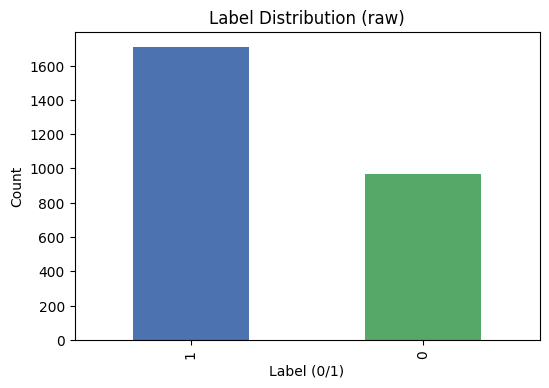

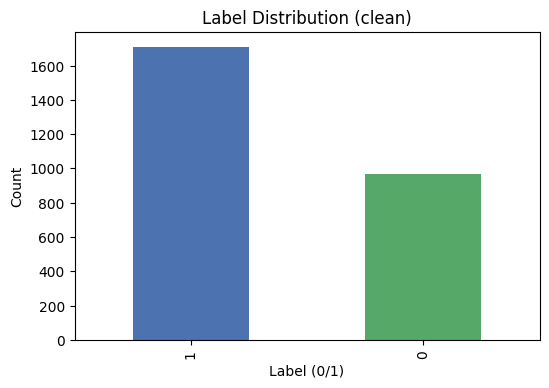

In [44]:
# label distribution

def plot_label_distribution(df, name_suffix):
    fig = plt.figure(figsize=(6,4))
    df['label'].value_counts().plot(kind='bar', color=['#4C72B0','#55A868'])
    plt.title(f"Label Distribution ({name_suffix})")
    plt.xlabel("Label (0/1)")
    plt.ylabel("Count")
    save_plot(fig, f"label_distribution_{name_suffix}.png")
    plt.show()
plot_label_distribution(df_raw, "raw")
plot_label_distribution(df_clean, "clean")

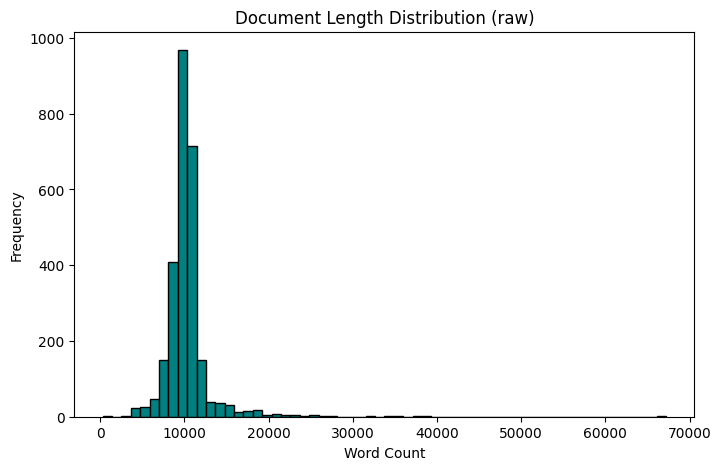

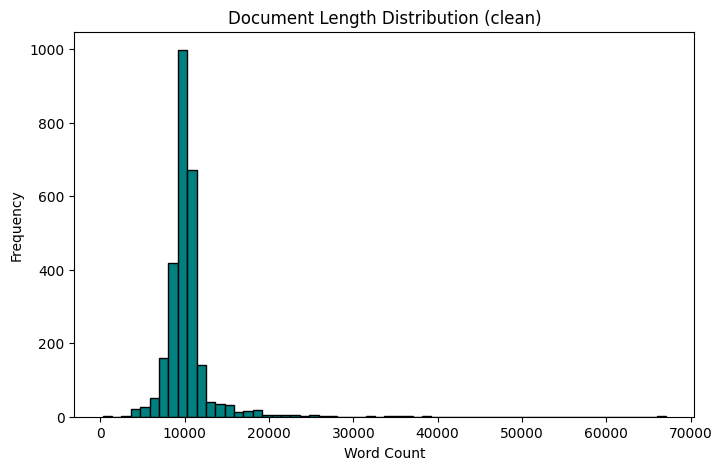

In [45]:
# document length distribution

def plot_length_distribution(df, name_suffix):
    lengths = df['text'].apply(lambda t: len(t.split()))
    fig = plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=60, color='teal', edgecolor='black')
    plt.title(f"Document Length Distribution ({name_suffix})")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    save_plot(fig, f"text_length_distribution_{name_suffix}.png")
    plt.show()
plot_length_distribution(df_raw, "raw")
plot_length_distribution(df_clean, "clean")

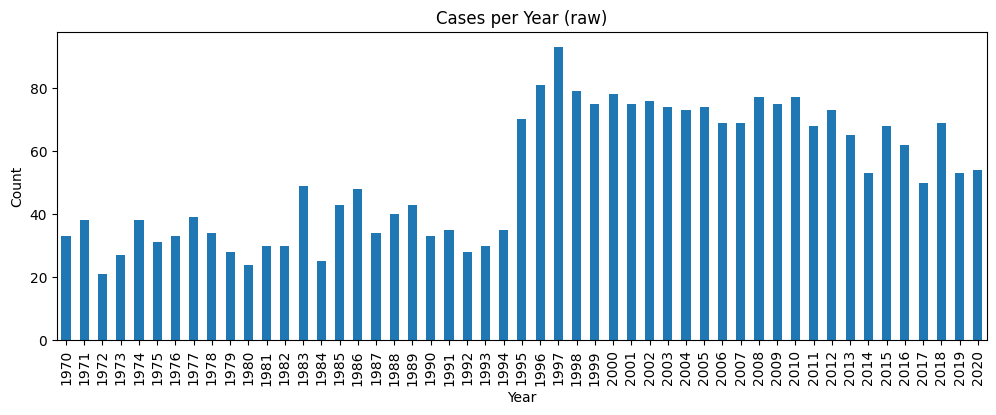

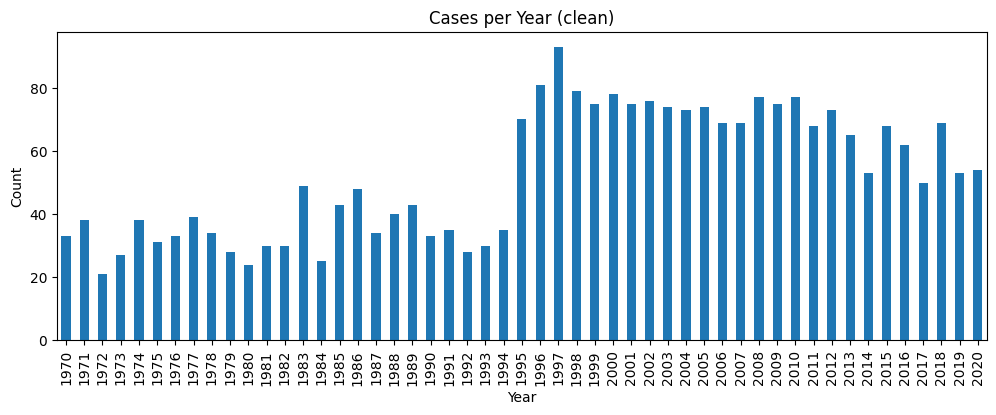

In [46]:
# year distribution

def plot_year_distribution(df, name_suffix):
    fig = plt.figure(figsize=(12,4))
    df['year'].value_counts().sort_index().plot(kind='bar')
    plt.title(f"Cases per Year ({name_suffix})")
    plt.xlabel("Year")
    plt.ylabel("Count")
    save_plot(fig, f"year_distribution_{name_suffix}.png")
    plt.show()
plot_year_distribution(df_raw, "raw")
plot_year_distribution(df_clean, "clean")

In [47]:
# leakage words comparison

def leakage_keyword_analysis(df, name_suffix):
    keywords = ["affirm", "revers", "vacat", "remand"]
    counts = {k: df['text'].str.contains(k, case=False).sum() for k in keywords}
    leakage_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
    display(leakage_df)
    leakage_df.to_csv(f"{results_path}/leakage_keywords_{name_suffix}.csv")
leakage_keyword_analysis(df_raw, "raw")
leakage_keyword_analysis(df_clean, "clean")

,count
affirm,2175
revers,1817
vacat,480
remand,1066


,count
affirm,81
revers,12
vacat,0
remand,1


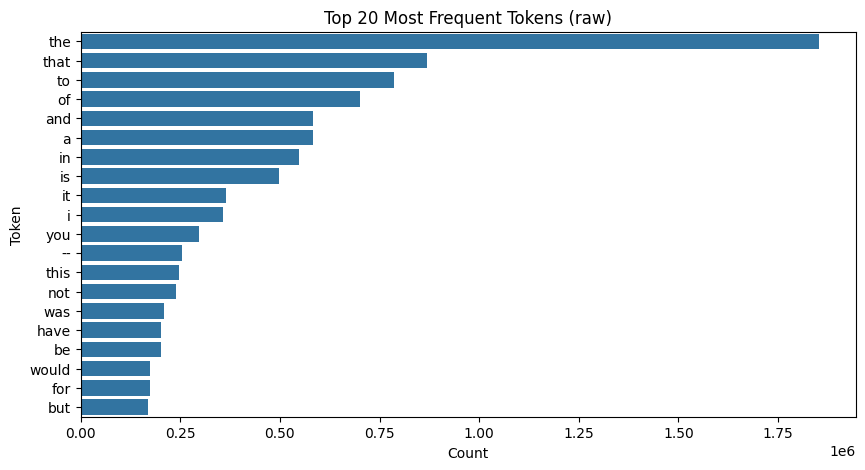

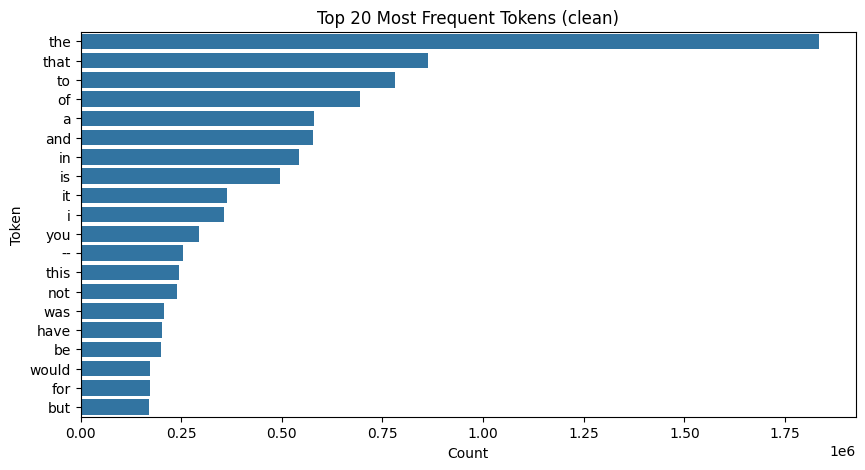

In [48]:
from collections import Counter

def plot_top_tokens(df, name_suffix):
    wc = Counter()
    for text in df["text"]:
        wc.update(text.lower().split())
    top = wc.most_common(20)
    words = [w for w, _ in top]
    counts = [c for _, c in top]
    fig = plt.figure(figsize=(10,5))
    sns.barplot(x=counts, y=words)
    plt.title(f"Top 20 Most Frequent Tokens ({name_suffix})")
    plt.xlabel("Count")
    plt.ylabel("Token")
    save_plot(fig, f"top20_tokens_{name_suffix}.png")
    plt.show()
plot_top_tokens(df_raw, "raw")
plot_top_tokens(df_clean, "clean")